In [1]:
'''
必要に応じて !pip install 
'''
import tensorflow as tf
import string
import re
import csv
import numpy as np
import random
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import files

In [2]:
'''
ここの部分は後々改良
'''
uploaded = files.upload()

Saving ja-en.csv to ja-en.csv


In [ ]:
#!pwd
!ls

ja-en.csv  sample_data


In [18]:
#データ数増やす場合はgoogle driveに
#csvかtxt..etc..


name_csv = "ja-en.csv"

ja_train_text = []
en_train_text = []
train_pairs = []
val_pairs = []
test_pairs = []

with open(name_csv, newline='') as csvfile:
  reader = csv.DictReader(csvfile)
  
  for row in reader:
    ja_train_text.append(row['Japanese'])
    en_train_text.append(row['English'])
    row['English'] = "\\" + " " + row['English'] +"|||"
    #ここの感覚は調整する
    #trainとval　を同じデータ、シャッフルするだけにしたらどうなるのか

    #学習データ：検証データ：テストデータ=8,1,1がよいらしいので。
    train_pairs.append((row['Japanese'],row['English']))
    random.shuffle(train_pairs)
  #print(len(train_pairs))

  for i in range(len(train_pairs)//10):
    val_pairs.append(train_pairs.pop(0))
    test_pairs.append(train_pairs.pop(0))
  #print(len(train_pairs))





In [19]:
len(train_pairs)//10

424

In [20]:
print(len(train_pairs))
print(len(val_pairs))
print(len(test_pairs))

4244
530
530


In [ ]:
#適当に確認

#print(ja_train_text[700])
#print(en_train_text[700])
#print(train_pairs)
#print(val_pairs)

In [ ]:
#データのシャッフルはいらない
#とりあえずcsvにある約5000のデータで学習させる


In [21]:
#あとで数値をいじる
vocab_size = 10000
sequence_length = 20

vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

vectorization.adapt(ja_train_text)
vectorization.adapt(en_train_text)
#print(ja_train_text)
#print(en_train_text)

In [22]:
#データセットの件数が数百件程度であれば32, 64、数万件程度であれば1024, 2048　でtry


batch_size = 128

def format_dataset(ja, en):
    ja = vectorization(ja)
    en = vectorization(en)
    #ここでスライスするかどうかで変えられる
    '''
    japanese"、"english"にしないとエラー
    '''
    return ({"japanese": ja,
        "english": en,
    }, en)


def make_dataset(pairs):
    ja_texts, en_texts = zip(*pairs)
    ja_texts = list(ja_texts)
    en_texts = list(en_texts)
    dataset = tf.data.Dataset.from_tensor_slices((ja_texts, en_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [23]:
embed_dim = 256
latent_dim = 1024

source = keras.Input(shape=(None,), dtype="int64", name="japanese")

x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(source)
encoded_source = layers.Bidirectional(
    layers.GRU(latent_dim), merge_mode="sum")(x)

past_target = keras.Input(shape=(None,), dtype="int64", name="english")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(past_target)
decoder_gru = layers.GRU(latent_dim, return_sequences=True)
x = decoder_gru(x, initial_state=encoded_source)
x = layers.Dropout(0.5)(x)
target_next_step = layers.Dense(vocab_size, activation="softmax")(x)
seq2seq_rnn = keras.Model([source, past_target], target_next_step)

In [24]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['japanese'].shape: {inputs['japanese'].shape}")
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"targets.shape: {targets.shape}")

#format_datasetのところで調整可能 

inputs['japanese'].shape: (128, 20)
inputs['english'].shape: (128, 20)
targets.shape: (128, 20)


['japanese']


In [32]:
#RNNでseq2seqで訓練

seq2seq_rnn.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])


#損失関数の値が収束するような、epochs数に調整を行う。
seq2seq_rnn.fit(train_ds, 
                epochs=3, 
                validation_data=val_ds)


Epoch 1/3
34/34 [==============================] - 321s 9s/step - loss: 1.2065 - accuracy: 0.5923 - val_loss: 1.1991 - val_accuracy: 0.6251
Epoch 2/3
34/34 [==============================] - 292s 9s/step - loss: 0.9823 - accuracy: 0.6680 - val_loss: 1.0731 - val_accuracy: 0.6852
Epoch 3/3
34/34 [==============================] - 293s 9s/step - loss: 0.8069 - accuracy: 0.7260 - val_loss: 1.0138 - val_accuracy: 0.7175


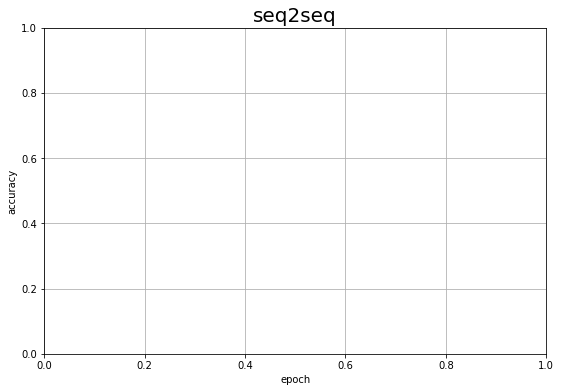

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 6))
#plt.plot(1 + np.arange(len(acc_list)), acc_list, marker='o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('seq2seq', fontsize=20)
plt.ylim(0, 1) # y軸の表示範囲
plt.grid() # グリッド線
plt.show()

In [ ]:
#Epochが引き継いでる?


#https://blog.octopt.com/sequence-to-sequence/ を参考にして次やってみる


In [ ]:

#モデル保存などもやりたい

#損失関数の収束状況を見たい。

In [35]:
'''
#原因解明をする


vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

ここか
したのプログラム
'''


eng_vocab = vectorization.get_vocabulary()
eng_index_lookup = dict(zip(range(len(eng_vocab)), eng_vocab))
max_decoded_sentence_length = 20 

def decode_sequence(input_sentence):
    tokenized_input_sentence = vectorization([input_sentence])
    decoded_sentence = "\\ "
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = vectorization([decoded_sentence])
        next_token_predictions = seq2seq_rnn.predict(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = eng_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "|||":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
皆何倍もの運動能力を持っている
\  site site site site site site site site site site site site site site site site site site site site
-
彼が久しぶりに極楽気分を味わいました
\  site site site site site site site site site site site site site site site site site site site site
-
彼がブログ記事を検索しました
\  site site site site site site site site site site site site site site site site site site site site
-
Xを皆が避けました
\  site site site site site site site site site site site site site site site site site site site site
-
受講した方には、受講修了証明書を発行します
\  site site site site site site site site site site site site site site site site site site site site
-
彼は完全に自分の世界に入っている
\  site site site site site site site site site site site site site site site site site site site site
-
それが山田には大きな意味合いを持つ
\  site site site site site site site site site site site site site site site site site site site site
-
Xに心から敬意を表します
\  site site site site site site site site site site site site site site site site site site site site
-
彼はその人の名前を聞かなかった
\  site site

In [ ]:
'''
epoch1の出力


-
彼がイベントを１日で３回もやった
\  and the the the the the the the the the the the the the the the the the the the
-
彼が時間の大半を仕事に費やします
\  and the the the the the the the the the the the the the the the the the the the
-
それが非常に示唆に富んでいた
\  and the the the the the the the the the the the the the the the the the the the
-
彼が９地点で大気中の水銀濃度を測定しました
\  and the the the the the the the the the the the the the the the the the the the
-
彼が嬉しそうに、満面の笑顔を浮かべる
\  and the the the the the the the the the the the the the the the the the the the
-
それが１７年度の集計ページへリンクします
\  and the the the the the the the the the the the the the the the the the the the
-
より一層の取り組みが求められる
\  and the the the the the the the the the the the the the the the the the the the
-
料金には、基本料金・保険及び車両・対物事故時の免責補償制度加入料金・消費税が含まれます
\  and the the the the the the the the the the the the the the the the the the the
-
彼がそのままバスで京都空港へと向かいました
\  and the the the the the the the the the the the the the the the the the the the
-
規定がなお効力を有する
\  and the the the the the the the the the the the the the the the the the the the
-
必ず運命の人が現れる
\  and the the the the the the the the the the the the the the the the the the the
-
思わず力が入ります
\  and the the the the the the the the the the the the the the the the the the the
-
協議会出納員は，協議会の出納その他の会計事務を司どる
\  and the the the the the the the the the the the the the the the the the the the
-
妊娠中の方から、時々質問を頂きました
\  and the the the the the the the the the the the the the the the the the the the
-
むしろ、その可能性のほうが高い
\  and the the the the the the the the the the the the the the the the the the the
-
お得意様のニーズに応えられるよう、なお一層の努力を重ねます
\  and the the the the the the the the the the the the the the the the the the the
-
思わず誰もが美しさに目を奪われる
\  and the the the the the the the the the the the the the the the the the the the
-
そのほうが絶対楽しい
\  and the the the the the the the the the the the the the the the the the the the
-
私は、小銭を手にすると、なんだか元気が出ます
\  and the the the the the the the the the the the the the the the the the the the
-
彼がアメリカを代表する
\  and the the the the the the the the the the the the the the the the the the the

'''

In [ ]:
'''

Epoch 1/2
34/34 [==============================] - 302s 9s/step - loss: 1.7823 - accuracy: 0.4003 - val_loss: 1.5987 - val_accuracy: 0.4838
Epoch 2/2
34/34 [==============================] - 290s 9s/step - loss: 1.4114 - accuracy: 0.5166 - val_loss: 1.3820 - val_accuracy: 0.5649
<keras.callbacks.History at 0x7fb1dc245a50>



-
彼が楽しく簡単にネットで金を稼ぎます
\  every every company company company company company company company company company company company company company company company company company company
-
規定がなお効力を有する
\  every every company company company company company company company company company company company company company company company company company company
-
Xが私を苦しめた
\  every every company company company company company company company company company company company company company company company company company company
-
ポリフェノールが体内の活性酸素を除去する
\  every every company company company company company company company company company company company company company company company company company company
-
温泉でゆっくり体を温めます
\  every every company company company company company company company company company company company company company company company company company company
-
明日はパンにする
\  every every company company company company company company company company company company company company company company company company company company
-
Xを誰もが確信する
\  every every company company company company company company company company company company company company company company company company company company
-
問題は自分がどちらの道を選ぶかだ
\  every every company company company company company company company company company company company company company company company company company company
-
そういう人を相手にしません
\  every every company company company company company company company company company company company company company company company company company company
-
彼が更に活動の範囲を広げる
\  every every company company company company company company company company company company company company company company company company company company
-
それが現在では末期癌患者の治療に一定の効果を上げています
\  every every company company company company company company company company company company company company company company company company company company
-
彼が治療指導の方法を研究しました
\  every every company company company company company company company company company company company company company company company company company company
-
彼はネットで収入を得ている
\  every every company company company company company company company company company company company company company company company company company company
-
われわれがプロの生産技術者を育成します
\  every every company company company company company company company company company company company company company company company company company company
-
彼が久しぶりに家でピアノを弾く
\  every every company company company company company company company company company company company company company company company company company company
-
持ってないもんを人に薦めるな
\  every every company company company company company company company company company company company company company company company company company company
-
私はこの新機能を使っていません
\  every every company company company company company company company company company company company company company company company company company company
-
彼が全然人の話しを聞かない
\  every every company company company company company company company company company company company company company company company company company company
-
断然こっちのほうが早い
\  every every company company company company company company company company company company company company company company company company company company
-
ついに地球のすべてが分かると誰もが確信しました
\  every every company company company company company company company company company company company company company company company company company company
[ ]


'''